* Let install some required tools

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 1.6 MB/s eta 0:00:0000:0100:010m


In [10]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

* We load the data

In [38]:
def download_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close'].values, data.index

* Data preprocessing

In [26]:
def preprocess_data(data, sequence_length):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

    sequence = []
    targets  = []
    for i in range(len(data) - sequence_length):
        sequence.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])

    return np.array(sequence), np.array(targets), scaler

In [27]:
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

In [28]:
# 4. Build the Custom Transformer Model
class CustomTransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(CustomTransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(self.d_model)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output

In [29]:
# 5. Train the Model
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-1))  # Add extra dimension for feature
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [50]:
import time

[*********************100%%**********************]  1 of 1 completed


Epoch 1/20, Loss: 0.0015
Epoch 2/20, Loss: 0.0011
Epoch 3/20, Loss: 0.0007
Epoch 4/20, Loss: 0.0003
Epoch 5/20, Loss: 0.0003
Epoch 6/20, Loss: 0.0002
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0001
Epoch 10/20, Loss: 0.0008
Epoch 11/20, Loss: 0.0002
Epoch 12/20, Loss: 0.0001
Epoch 13/20, Loss: 0.0004
Epoch 14/20, Loss: 0.0002
Epoch 15/20, Loss: 0.0002
Epoch 16/20, Loss: 0.0003
Epoch 17/20, Loss: 0.0002
Epoch 18/20, Loss: 0.0003
Epoch 19/20, Loss: 0.0002
Epoch 20/20, Loss: 0.0000


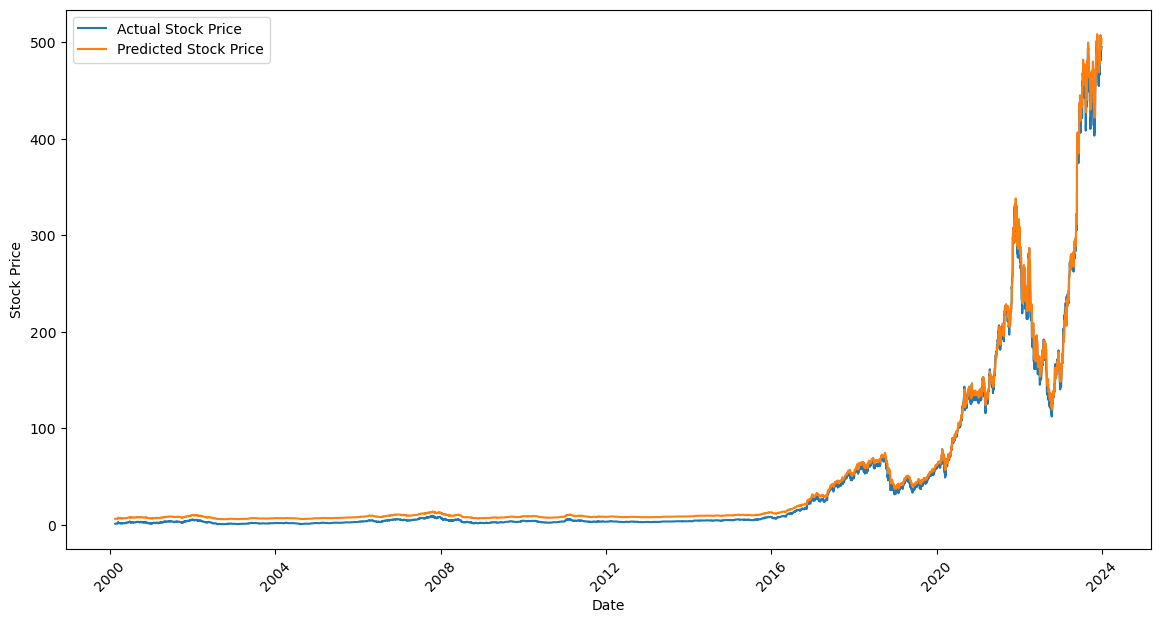

In [77]:
# 6. Main Function
if __name__ == "__main__":
    time_rec = []
    #time_range = list(range(2001, 2024, 3))
    time_range = [2024]
    for year in time_range:
        # Parameters
        TICKER = 'NVDA'
        START_DATE = '2000-01-01'
        END_DATE = '{}-01-01'.format(year)
        SEQUENCE_LENGTH = 30
        BATCH_SIZE = 32
        EPOCHS = 20
        INPUT_SIZE = 1
        D_MODEL = 64
        NHEAD = 4
        NUM_LAYERS = 2
        DIM_FEEDFORWARD = 128
        DROPOUT = 0.1

        # Download and preprocess data
        data, dates = download_stock_data(TICKER, START_DATE, END_DATE)
        sequences, targets, scaler = preprocess_data(data, SEQUENCE_LENGTH)

        # Create DataLoader 
        dataset = StockDataset(sequences, targets)
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Initialize model, criterion, and optimizer
        model = CustomTransformerModel(INPUT_SIZE, D_MODEL, NHEAD, NUM_LAYERS, DIM_FEEDFORWARD, DROPOUT)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        start =  time.time()
        train_model(model, train_loader, criterion, optimizer, EPOCHS)
        end = time.time() - start
        time_rec.append(end)

        # Save the model
        torch.save(model.state_dict(), 'custom_transformer_stock_model.pth')

        # Visualization
        model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(len(sequences)):
                input_seq = torch.tensor(sequences[i], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
                pred = model(input_seq).item()
                predictions.append(pred)

        # Inverse transform the predictions and targets
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1)
        targets = scaler.inverse_transform(targets.reshape(-1, 1)).reshape(-1)

        # Plot the results
        plt.figure(figsize=(14, 7))
        plt.plot(dates[SEQUENCE_LENGTH:], data[SEQUENCE_LENGTH:], label='Actual Stock Price')
        plt.plot(dates[SEQUENCE_LENGTH:], predictions, label='Predicted Stock Price')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

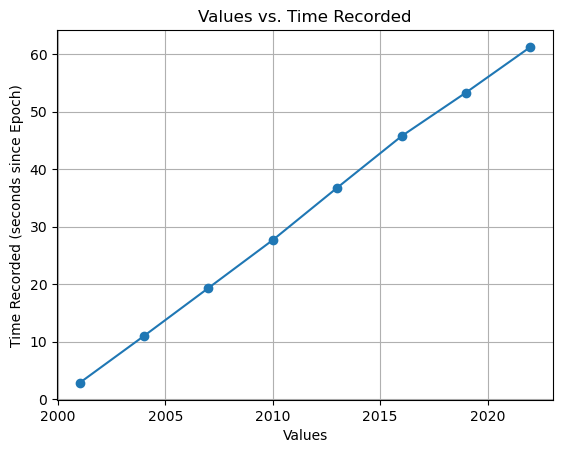

In [64]:
plt.plot(time_range, time_rec, marker='o')
plt.xlabel('Values')
plt.ylabel('Time Recorded (seconds since Epoch)')
plt.title('Values vs. Time Recorded')
plt.grid(True)
plt.show()